# Ejemplo de ajuste no lineal

Ejemplo didáctico sobre cómo hacer ajustes no lineales de una función armónica


## Imports y funciones auxiliares (correr una vez)

In [18]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Toolkit para ajustes no lineales.

Ejemplo para una función armónica

"""


# Importamos librerías estándares

from numpy import *
import matplotlib.pyplot as plt


"""
Este archivo se organizará por bloques
En cada bloque se realizará algún paso de la tarea
"""

#%% Funciones auxiliares ######################################################

from scipy.stats.distributions import  t,chi2

def estadistica(datos_x,datos_y,modelo,pcov,parametros,nombres=None,modelo_x_arr=None,alpha=0.05):

    if nombres is None:
        nombres = [ f'{j}' for j in range(len(parametros)) ]

    # Cantidad de parámetros
    P = len(parametros)

    # Número de datos
    N = len(datos_x)

    # Grados de libertas (Degrees Of Freedom)
    dof = N-P-1

    # Cauculamos coordenadas del modelo
    modelo_x    = datos_x if modelo_x_arr is None else modelo_x_arr
    modelo_y    = modelo( modelo_x, *parametros )

    # Predicción del modelo para los datos_x medidos
    prediccion_modelo = modelo( datos_x, *parametros )

    # Calculos de cantidades estadísticas relevantes
    COV       = pcov                                      # Matriz de Covarianza
    SE        = sqrt(diag( COV  ))                        # Standar Error / Error estandar de los parámetros
    residuos  = datos_y - prediccion_modelo               # diferencia enrte el modelo y los datos

    SSE       = sum(( residuos )**2 )                     # Resitual Sum of Squares
    SST       = sum(( datos_y - mean(datos_y))**2)        # Total Sum of Squares

    # http://en.wikipedia.org/wiki/Coefficient_of_determination
    # Expresa el porcentaje de la varianza que logra explicar el modelos propuesto
    Rsq       =  1 - SSE/SST                               # Coeficiente de determinación
    Rsq_adj   = 1-(1-Rsq) * (N-1)/(N-P-1)                  # Coeficiente de determinación Ajustado

    # https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#In_least_squares_regression_analysis
    # Expresa la correlación que hay entre los datos y la predicción del modelo
    r_pearson = corrcoef( datos_y ,  prediccion_modelo )[0,1]

    # Reduced chi squared
    # https://en.wikipedia.org/wiki/Reduced_chi-squared_statistic
    chi2_red  = sum( residuos**2 )/(N-P)

    # Chi squared test
    chi2_test = sum( residuos**2 / abs(prediccion_modelo) )
    # p-value del ajuste
    p_val  = chi2(dof).cdf( chi2_test )


    sT = t.ppf(1.0 - alpha/2.0, N - P ) # student T multiplier
    CI = sT * SE                        # Confidence Interval

    print('R-squared    ',Rsq)
    print('R-sq_adjusted',Rsq_adj)
    print('chi2_test    ',chi2_test)
    print('r-pearson    ',r_pearson)
    print('p-value      ',p_val)
    print('')
    print('Error Estandard (SE):')
    for i in range(P):
        print(f'parametro[{nombres[i]:>5s}]: ' , parametros[i], ' ± ' , SE[i])
    print('')
    print('Intervalo de confianza al '+str((1-alpha)*100)+'%:')
    for i in range(P):
        print(f'parametro[{nombres[i]:>5s}]: ' , parametros[i], ' ± ' , CI[i])

    return dict(R2=Rsq,R2_adj=Rsq_adj,chi2=chi2_test,r=r_pearson,pvalue=p_val,
                SE=SE,CI=CI)


## Creamos datos (simulados) con ruido para practicar un ajuste

In [19]:
#%% Fabricamos datos inventados con ruido

# Parámetros de la señal
frecuencia            = 8
fase0                 = 54 /180*pi
amplitud              = 2.5
offset                = 0.4

# línea de tiempo
tiempo                = arange(0,2,0.001)

# ruidos
random.seed(13)
ruido_en_frecuencia   = random.normal(size=len(tiempo))*30
ruido_en_frecuencia  -= ruido_en_frecuencia.mean()
frecuencia_con_ruido  = frecuencia*2*pi *ones(len(tiempo))+ ruido_en_frecuencia

fase                  = fase0 + cumsum( frecuencia_con_ruido )*diff(tiempo)[0]
volts                 = amplitud*sin(  fase)
volts_con_ruido       = volts * ( 1 + cumsum(random.normal(size=len(tiempo)))*diff(tiempo)[0]*3 )
volts_con_ruido      += random.normal(size=len(tiempo))*0.1
volts_con_ruido      += offset

# Graficamos -----------------
plt.plot(tiempo,offset+amplitud*sin(fase0+frecuencia*2*pi*tiempo) , label='señal sin ruidos')
plt.plot(tiempo,volts_con_ruido, label='señal con ruidos' , alpha=0.8)

plt.xlabel('tiempo [s]')
plt.ylabel('señal [V]')
plt.grid(ls=':')
plt.legend()
plt.title('Comparación de señal pura con datos ruidosos')


x_datos = tiempo.copy()
y_datos = volts_con_ruido.copy()

## Ejemplo de un mal uso de los parámetros iniciales

- En los ajustes no lineales es escencial partir de parámetros iniciales razonables.
- El algoritmo va a minimizar el error cuadrático usando esos parámetros como punto de partida
- Si el punto de partida no está cerca del cero global va a encontrar un óptimo local que nada tiene que ver con el óptimo que buscamos


Impresion cruda de los parametros:
[0.36794839 0.42926145 5.76587513 2.06558179]
Parámetros hallados:
A = 0.368 ± 0.060
y0 = 0.429 ± 0.042
f = 5.766 ± 0.045
fase = 2.066 ± 0.323
------------------------------



R-squared     0.018590904849480783
R-sq_adjusted 0.01662316731534441
chi2_test     31588.84610752202
r-pearson     0.13634846845300766
p-value       1.0

Error Estandard (SE):
parametro[    A]:  0.36794838800008867  ±  0.05984119842348196
parametro[   y0]:  0.4292614466155657  ±  0.042358716225502864
parametro[    f]:  5.765875133610795  ±  0.044944616869858484
parametro[ fase]:  2.0655817889425885  ±  0.322880101224809

Intervalo de confianza al 95.0%:
parametro[    A]:  0.36794838800008867  ±  0.11735775813655847
parametro[   y0]:  0.4292614466155657  ±  0.08307193212589452
parametro[    f]:  5.765875133610795  ±  0.08814327946486046
parametro[ fase]:  2.0655817889425885  ±  0.633217345656959
2000


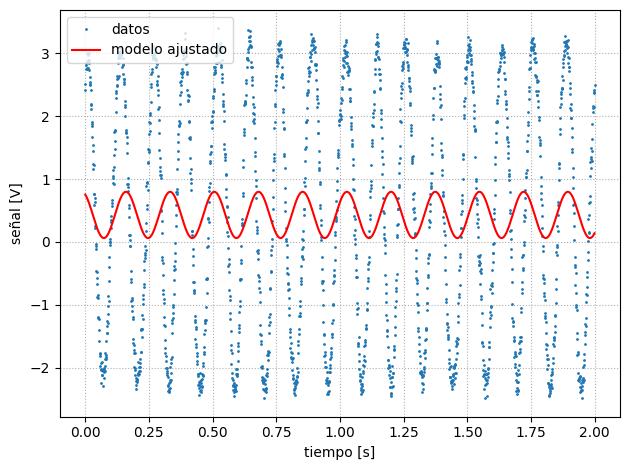

In [ ]:
#%% Ejemplo de ajuste no lineal con parámetros MALOS

"""
Usamos como referencia de código la explicación de esta web:
    https://marceluda.github.io/python-para-fisicos/tuto/labo2/03_ajustes/
"""

from scipy.optimize import curve_fit

def modelo(t, A,y0,f,fase):
    return A*sin(fase+2*pi*f*t)+y0

# Parámetros iniciales con los que vamos a iniciar el proceso de fiteo
parametros_iniciales=[2, 1, 6, 1]

# Hacemos el ajuste con curve_fit
parametros, pcov = curve_fit(modelo, x_datos, y_datos, p0=parametros_iniciales)

# curve_fit devuelve dos resultados. El primero (popt) son los
# parámetros óptimos hallados. El segundo (pcov) es la matriz de
# covarianza de los parámetros hallados.

x_modelo  = x_datos.copy()

plt.figure()
plt.plot( x_datos,                 y_datos,  '.',ms=2, label='datos')
# plt.plot(x_modelo, modelo(x_modelo, *parametros_iniciales), '-', label='modelo param iniciales')
plt.plot(x_modelo, modelo(x_modelo, *parametros), 'r-', label='modelo ajustado')
plt.legend(loc='best')
plt.xlabel('tiempo [s]')
plt.ylabel('señal [V]')
plt.grid(ls=':')
plt.tight_layout()


print("Impresion cruda de los parametros:")
print(parametros)

# De la matriz de covarinza podemos obtener
# el error estandar de los parámetros hallados
param_errores = sqrt(diag(pcov))

nombres_de_param = ['A', 'y0', 'f', 'fase']
print('Parámetros hallados:')
for nombre,parametro,error in zip(nombres_de_param,parametros,param_errores):
    print('{:s} = {:5.3f} ± {:5.3f}'.format( nombre , parametro , error) )

print('-'*30+'\n'*3)
estadistica(x_datos,y_datos,modelo,pcov,parametros,nombres=nombres_de_param)


parametros_minimo_local = parametros.copy()

## Ejemlo de tomar datos a mano (requiere Spyder)

Dos ejemplos para tomar datos de una curva. Uno para correr en spyder (con gráficos interactivos) y otro para usar en google Colab


### Para Spyder

Text(0.5, 1.0, 'Mediciones a mano sobre los datos')

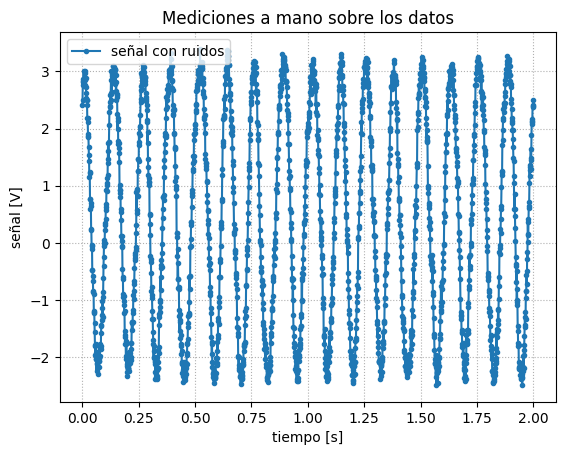

In [ ]:
#%% Ejemplo de medir variables sobre los datos ################################

"""
Ver en :
    https://marceluda.github.io/python-para-fisicos/tuto/labo2/toolkit_ajustes/
cómo debe estar configurado el Spyder para poder hacer esto
"""

def medir(N=1, timeout=60):
    puntos = array(plt.ginput(N, timeout=timeout))

    print("Puntos")
    for punto in puntos:
        print(punto)
    print("\n")
    if N>=2:
        print("Distancias")
        print(f"Δx: {diff(puntos[:,0])}")
        print(f"Δy: {diff(puntos[:,1])}")
        print("\n")

        print("Frecuencias")
        print(f"Δfx: {mean(1/diff(puntos[:,0]))}")
        print(f"Δfy: {mean(1/diff(puntos[:,1]))}")
        print("\n")

    return puntos

plt.figure()
plt.plot(tiempo,volts_con_ruido, '.-',label='señal con ruidos')

plt.xlabel('tiempo [s]')
plt.ylabel('señal [V]')
plt.grid(ls=':')
plt.legend()
plt.title('Mediciones a mano sobre los datos')

#medir(2)

### Para Colab

interactive(children=(FloatSlider(value=0.0, description='y_value1', max=3.6874613176418554, min=-2.7791228871…

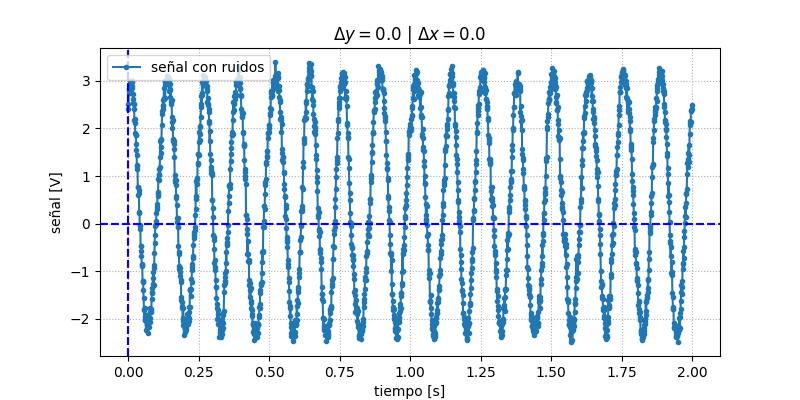

In [14]:
%matplotlib widget
# Usar el backend interactivo

from google.colab import output
output.enable_custom_widget_manager()

import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, FloatSlider



fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(tiempo,volts_con_ruido, '.-',label='señal con ruidos')

ax.set_xlabel('tiempo [s]')
ax.set_ylabel('señal [V]')
ax.grid(True,ls=':')
ax.legend()
ax.set_title('Mediciones a mano sobre los datos')

line_horizontal1 = ax.axhline(y=0, color='r', linestyle='--')  # Línea inicial en y=0
line_horizontal2 = ax.axhline(y=0, color='b', linestyle='--')  # Línea inicial en y=0
line_vertical1   = ax.axvline(x=0, color='r', linestyle='--')  # Línea vertical en x=0
line_vertical2   = ax.axvline(x=0, color='b', linestyle='--')  # Línea vertical en x=0


@interact(
    y_value1=FloatSlider(min=ax.get_ylim()[0], max=ax.get_ylim()[1], step=np.diff(ax.get_ylim())/100),
    y_value2=FloatSlider(min=ax.get_ylim()[0], max=ax.get_ylim()[1], step=np.diff(ax.get_ylim())/100),
    x_value1=FloatSlider(min=ax.get_xlim()[0], max=ax.get_xlim()[1], step=np.diff(ax.get_xlim())/100),
    x_value2=FloatSlider(min=ax.get_xlim()[0], max=ax.get_xlim()[1], step=np.diff(ax.get_xlim())/100)
)
def update_lines(y_value1, y_value2,x_value1,x_value2):
    line_horizontal1.set_ydata([y_value1, y_value1])
    line_horizontal2.set_ydata([y_value2, y_value2])
    line_vertical1.set_xdata([x_value1, x_value1])
    line_vertical2.set_xdata([x_value2, x_value2])
    ax.set_title(f'$\\Delta y=${round(y_value1-y_value2,4)} | $\\Delta x=${round(x_value1-x_value2,4)}')
    fig.canvas.draw()

plt.show()



## Ajuste con buenos parámetros

Impresion cruda de los parametros:
[2.59752632 0.4157481  8.03210691 0.71201735]
Parámetros hallados:
A = 2.598 ± 0.016
y0 = 0.416 ± 0.012
f = 8.032 ± 0.002
fase = 0.712 ± 0.013
------------------------------



R-squared     0.9266096243675322
R-sq_adjusted 0.9264624757447103
chi2_test     1266.7475741069557
r-pearson     0.9626056432244371
p-value       8.229086212219747e-41

Error Estandard (SE):
parametro[    A]:  2.597526315512523  ±  0.016362734055676193
parametro[   y0]:  0.41574809504454185  ±  0.011582569142193659
parametro[    f]:  8.032106912552196  ±  0.0017407330201866511
parametro[ fase]:  0.7120173470551359  ±  0.012703017894488376

Intervalo de confianza al 95.0%:
parametro[    A]:  2.597526315512523  ±  0.0320898283515215
parametro[   y0]:  0.41574809504454185  ±  0.02271519260643904
parametro[    f]:  8.032106912552196  ±  0.003413844143255363
parametro[ fase]:  0.7120173470551359  ±  0.024912564269113053


<Figure size 640x480 with 0 Axes>

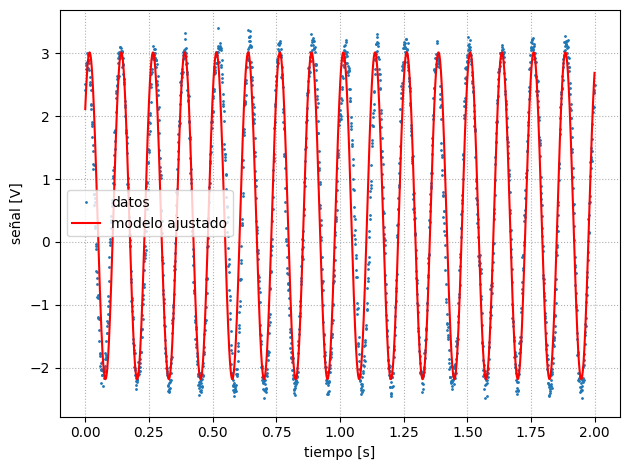

In [22]:
#%% Ejemplo de ajuste no lineal

"""
Usamos como referencia de código la explicación de esta web:
    https://marceluda.github.io/python-para-fisicos/tuto/labo2/03_ajustes/
"""
plt.clf()
%matplotlib inline

from scipy.optimize import curve_fit

def modelo(t, A,y0,f,fase):
    return A*sin(fase+2*pi*f*t)+y0

# Parámetros iniciales con los que vamos a iniciar el proceso de fiteo
parametros_iniciales=[2.5, 0, 8, 0]

# Hacemos el ajuste con curve_fit
parametros, pcov = curve_fit(modelo, x_datos, y_datos, p0=parametros_iniciales)

# curve_fit devuelve dos resultados. El primero (popt) son los
# parámetros óptimos hallados. El segundo (pcov) es la matriz de
# covarianza de los parámetros hallados.

x_modelo  = x_datos.copy()

plt.figure()
plt.plot( x_datos, y_datos, '.',ms=2, label='datos')
# plt.plot(x_modelo, modelo(x_modelo, *parametros_iniciales), '-', label='modelo param iniciales')
plt.plot(x_modelo, modelo(x_modelo, *parametros), 'r-', label='modelo ajustado')
plt.legend(loc='best')
plt.xlabel('tiempo [s]')
plt.ylabel('señal [V]')
plt.grid(ls=':')
plt.tight_layout()


print("Impresion cruda de los parametros:")
print(parametros)

# De la matriz de covarinza podemos obtener
# el error estandar de los parámetros hallados
param_errores = sqrt(diag(pcov))

nombres_de_param = ['A', 'y0', 'f', 'fase']
print('Parámetros hallados:')
for nombre,parametro,error in zip(nombres_de_param,parametros,param_errores):
    print('{:s} = {:5.3f} ± {:5.3f}'.format( nombre , parametro , error) )

print('-'*30+'\n'*3)
rta=estadistica(x_datos,y_datos,modelo,pcov,parametros,nombres=nombres_de_param)

parametros_minimo_global = parametros.copy()

## Visualización de la superficie 3D de la función a minimizar

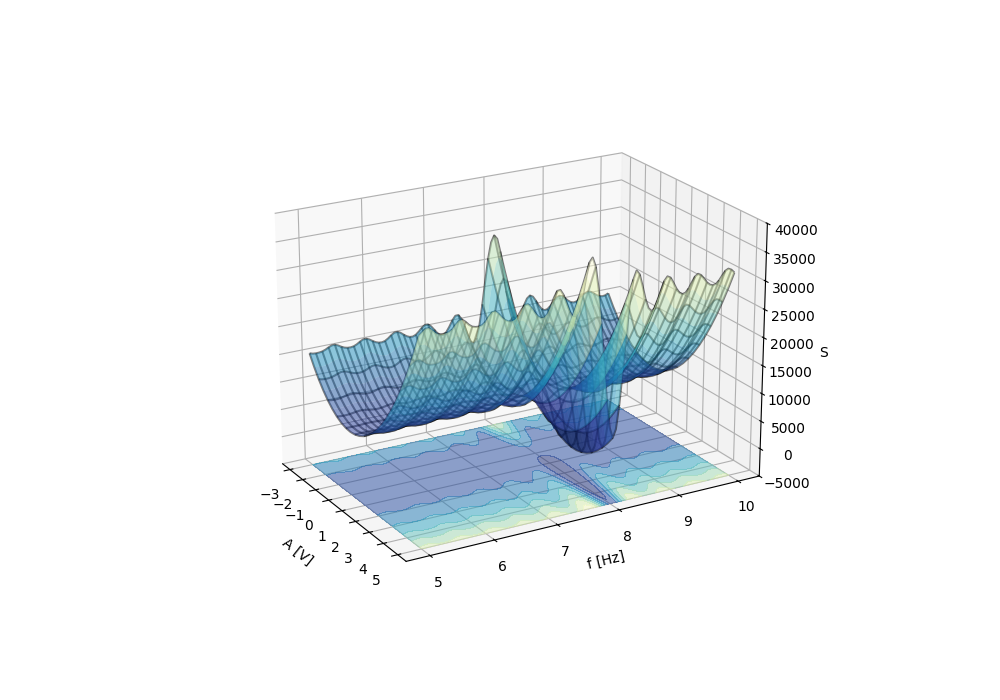

In [27]:
#%% Visualización superficie 3D (en SOLO dos parámetros)
%matplotlib widget


from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

plt.close('all')

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# load some test data for demonstration and plot a wireframe
#X, Y, Z = axes3d.get_test_data(0.1)

N=25

def modelo_3d(tiempo, A,f ):
    return [ modelo(tt,A,0.4,f,0.7) for tt in tiempo ]


def S(a,b):
    Z=0
    for dato,model in zip(y_datos,modelo_3d(x_datos,a,b)):
        Z+= ( dato - model )**2
    return Z


a = linspace(-3, 5, N)
b = linspace(5,10, N*4)
A, B = meshgrid(a, b)



#A = outer(linspace(0, 2, N), ones(N))
#B = outer(linspace(0, 4, N), ones(N)).copy().T
Z = S(A,B)

ax.plot_wireframe(A, B, Z, rstride=2, cstride=2, color='black', alpha=0.5)
suf = ax.plot_surface(A, B, Z, cmap=plt.cm.YlGnBu_r , alpha=0.5)
ax.contourf(    A, B, Z, zdir='z', offset=-5000, cmap=plt.cm.YlGnBu_r , alpha=0.5)


if False:
    ax.plot(        [parametros_minimo_global[0]]*2, [B.min(),B.max()], zs=-5000, zdir='z', color='black')
    ax.plot(    [A.min(),A.max()],[parametros_minimo_global[2]]*2     , zs=-5000, zdir='z', color='black')
    ax.plot( parametros_minimo_global[0], parametros_minimo_global[2], 'o',zs=-5000, zdir='z', color='black')

    ax.plot(        [parametros_minimo_local[0]]*2, [B.min(),B.max()], zs=-5000, zdir='z', color='red')
    ax.plot(    [A.min(),A.max()],[parametros_minimo_local[2]]*2     , zs=-5000, zdir='z', color='red')
    ax.plot( parametros_minimo_local[0], parametros_minimo_local[2], 'o',zs=-5000, zdir='z', color='red')
    plt.draw()

if False:
    ax.plot( a, ones(len(a))*8.03   , [ S(aa,8.03) for aa in a ] , color='red', lw=6)
    ax.plot( ones(len(b))*2.598, b , [ S(2.598,bb) for bb in b ] , color='blue', lw=6)
    suf.set_alpha(0.1)
    suf.set_linewidths(0.1)
    plt.draw()

ax.view_init(21, -30)

# ax.set_xticks( arange(0,2.1,0.5))
# ax.set_yticks( arange(-1,6.1,2))

ax.set_zlim(-5000,40e3)
ax.set_xlabel('A [V]')
ax.set_ylabel('f [Hz]')
ax.set_zlabel(r'S')

ax.set_box_aspect((1,1.5,1))



# Ejemplo de análisis COMPLETO

## Generacion de datos para ajustar (correr una vez)

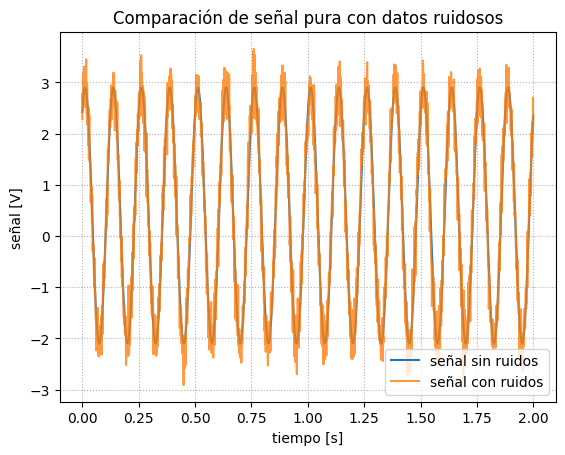

In [28]:

#%% Rearmado de ruidos
%matplotlib inline
plt.close('all')


"""
Fabricamos datos con distintos tipos de ruido para demostración
"""


# Parámetros de la señal
frecuencia            = 8
fase0                 = 54 /180*pi
amplitud              = 2.5
offset                = 0.4

# línea de tiempo
tiempo                = arange(0,2,0.001)

# ruidos
random.seed(13)
ruido_en_frecuencia   = 0
# ruido_en_frecuencia   = random.normal(size=len(tiempo))*30
# ruido_en_frecuencia  -= ruido_en_frecuencia.mean()
frecuencia_con_ruido  = frecuencia*2*pi *ones(len(tiempo))+ ruido_en_frecuencia

fase                  = fase0 + cumsum( frecuencia_con_ruido )*diff(tiempo)[0]
volts                 = amplitud*sin(  fase)
volts_con_ruido       = volts
# volts_con_ruido      *= ( 1 + cumsum(random.normal(size=len(tiempo)))*diff(tiempo)[0]*3 )
volts_con_ruido      += random.normal(size=len(tiempo))*0.3
volts_con_ruido      += offset

# Graficamos -----------------
# plt.close('all')
plt.figure()
plt.plot(tiempo,offset+amplitud*sin(fase0+frecuencia*2*pi*tiempo) , label='señal sin ruidos')
plt.plot(tiempo,volts_con_ruido, label='señal con ruidos' , alpha=0.8)

plt.xlabel('tiempo [s]')
plt.ylabel('señal [V]')
plt.grid(ls=':')
plt.legend()
plt.title('Comparación de señal pura con datos ruidosos')


x_datos = tiempo.copy()
y_datos      = volts_con_ruido.copy()


## Ejemplo completo de ajuste

Impresion cruda de los parametros:
[2.49020995 0.3961079  8.00131267 0.9806828 ]
------------------------------

R-squared     0.9725472387175099
R-sq_adjusted 0.972492195587119
chi2_test     546.4932898303427
r-pearson     0.9861780968554869
p-value       6.71859773422141e-249

Error Estandard (SE):
parametro[    A]:  2.49020995156874  ±  0.009364858949613006
parametro[   y0]:  0.3961078983355348  ±  0.006627335937165503
parametro[    f]:  8.001312670205069  ±  0.0010378766005720744
parametro[ fase]:  0.9806828006128708  ±  0.0075777748883962765

Intervalo de confianza al 95.0%:
parametro[    A]:  2.49020995156874  ±  0.018365923152374574
parametro[   y0]:  0.3961078983355348  ±  0.012997221120130357
parametro[    f]:  8.001312670205069  ±  0.0020354350226003326
parametro[ fase]:  0.9806828006128708  ±  0.014861177516403598


Text(0.5, 1.0, 'Matriz de covarianza')

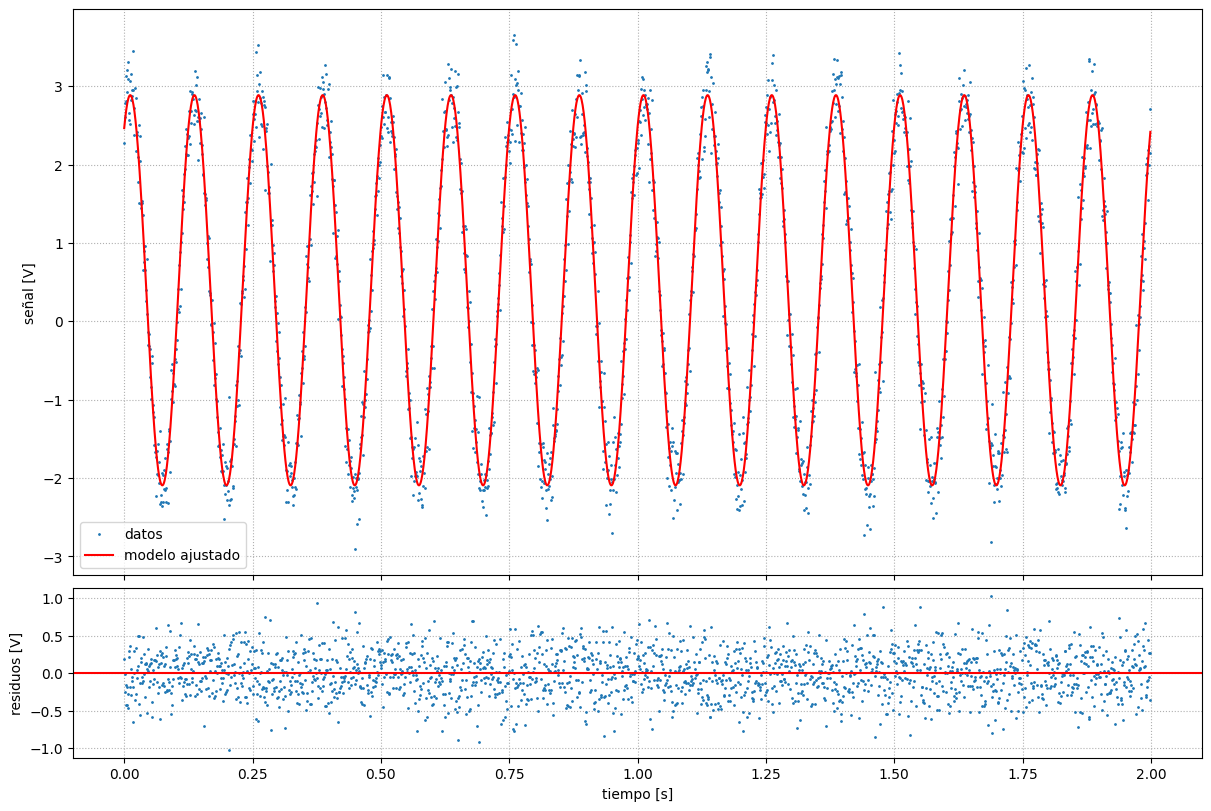

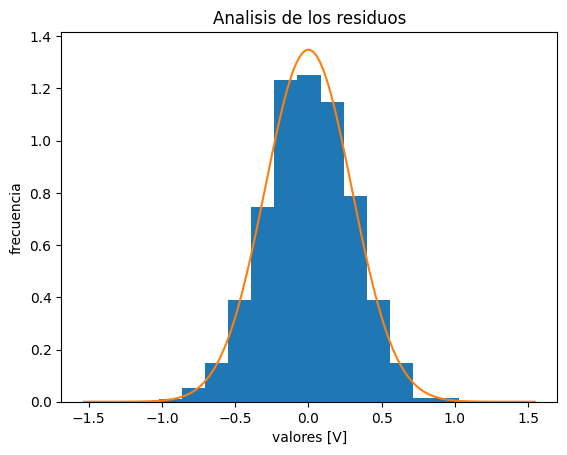

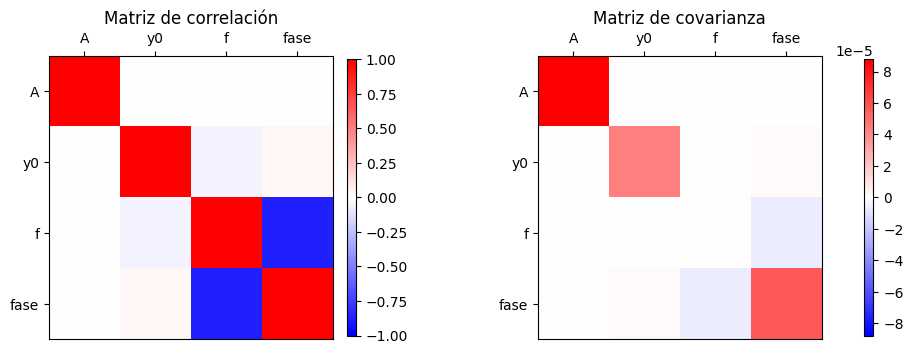

In [29]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%% Ejemplo de análisis COMPLETO ##############################################
###############################################################################

"""
Usamos como referencia de código la explicación de esta web:
    https://marceluda.github.io/python-para-fisicos/tuto/labo2/03_ajustes/
"""

from scipy.optimize import curve_fit

def modelo(t, A,y0,f,fase):
    return A*sin(fase+2*pi*f*t)+y0

# Parámetros iniciales con los que vamos a iniciar el proceso de fiteo
parametros_iniciales=[2.5, 0, 8, 0]

# Hacemos el ajuste con curve_fit
parametros, pcov = curve_fit(modelo, x_datos, y_datos, p0=parametros_iniciales)



residuos =  modelo(x_datos, *parametros) - y_datos
# curve_fit devuelve dos resultados. El primero (popt) son los
# parámetros óptimos hallados. El segundo (pcov) es la matriz de
# covarianza de los parámetros hallados.

x_modelo  = x_datos.copy()

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,8),  constrained_layout=True,
                              gridspec_kw={'height_ratios': [1,0.3]},
                              sharex=True)
# fig.set_constrained_layout_pads(w_pad=2/72, h_pad=2/72, hspace=0, wspace=0.2)


ax1.plot( x_datos,                 y_datos,  '.',ms=2, label='datos')
ax1.plot(x_modelo, modelo(x_modelo, *parametros), 'r-', label='modelo ajustado')
ax1.set_ylabel('señal [V]')
ax1.legend(loc='best')

ax2.plot( x_datos,             residuos,  '.',ms=2)
ax2.axhline( 0 , color='red')
ax2.set_ylabel('residuos [V]')
ax2.set_xlabel('tiempo [s]')

for ax in (ax1,ax2):
    ax.grid(ls=':')


print("Impresion cruda de los parametros:")
print(parametros)

# De la matriz de covarinza podemos obtener
# el error estandar de los parámetros hallados
param_errores = sqrt(diag(pcov))

nombres_de_param = ['A', 'y0', 'f', 'fase']
print('-'*30+'\n')
rta=estadistica(x_datos,y_datos,modelo,pcov,parametros,nombres=nombres_de_param)

parametros_minimo_global = parametros.copy()




# Análisis de los residuos

# Función de una gaussiana
def gaussiana(x,mu,sigma):
    """
    Devuelve el valor de una gausiana de valor medio mu
    con desviacion estandar sigma para cada valor de x
    """

    # Este paso es sólo para facilitar el cálculo como vector
    x = array(x)

    return exp( -(x-mu)**2/(2*sigma**2) ) / (sigma * sqrt(2*pi))


plt.figure()
valores,limites,_ = plt.hist(residuos,13 , density=True)

xx = linspace(limites.min()*1.5,limites.max()*1.5,200)
plt.plot( xx,  gaussiana(xx,residuos.mean(), residuos.std() ))
plt.title('Analisis de los residuos')
plt.ylabel('frecuencia')
plt.xlabel('valores [V]')




# Análisis de la matriz de correlación y de covarianza

def corrMat(data):
    rows, cols = data.shape

    corr_mat = data * 0
    for i in range(rows):
        for j in range(cols):
            x_dev = sqrt(data[i,i])
            y_dev = sqrt(data[j,j])
            corr_mat[i][j] = data[i,j] / ( x_dev * y_dev )
    return corr_mat


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(9,4),  constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=2/72, h_pad=2/72, hspace=0, wspace=0.2)


cov_matrix = pcov
cor_matrix = corrMat(cov_matrix)


img = ax1.imshow(cor_matrix, cmap='bwr')
img.set_clim(-1,1)
ax1.xaxis.tick_top()
ax1.set_xticks( arange(len(nombres_de_param)) )
ax1.set_xticklabels( nombres_de_param   )
ax1.set_yticks( arange(len(nombres_de_param)) )
ax1.set_yticklabels( nombres_de_param   )
fig.colorbar(img,ax=ax1,shrink=0.7,aspect=30)
ax1.set_title('Matriz de correlación')

img = ax2.imshow(cov_matrix, cmap='bwr')
img.set_clim(-abs(cov_matrix).max(),abs(cov_matrix).max())
ax2.xaxis.tick_top()
ax2.set_xticks( arange(len(nombres_de_param)) )
ax2.set_xticklabels( nombres_de_param   )
ax2.set_yticks( arange(len(nombres_de_param)) )
ax2.set_yticklabels( nombres_de_param   )
fig.colorbar(img,ax=ax2,shrink=0.7,aspect=30)
ax2.set_title('Matriz de covarianza')